<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model Training</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

# Determining the age of customers

ABC grocery store introduces a computer vision system for processing customers' photos. Photo fixation in the checkout area will help determine the age of customers in order to:

* Analyze purchases and offer products that may be of interest to buyers of this age group;
* Control the conscientiousness of cashiers when selling alcohol.

We need to build a model that will determine the approximate age of a person from a photograph. At our disposal is a set of photographs of people with age indication.

The purpose of the project: To build a model for the regression problem, which will determine the approximate age of a person from a photograph.

Research steps:

1. Exploratory data analysis.
2. Model training.
3. Conclusion.

## Exploratory Data Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings("ignore")

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Let's look at the size of the original dataset.

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.shape

(7591, 2)

Our sample consists of 7591 images. The `labels` table has two columns that contain the file name and the target variable - the real age of the customer.

Since the number of images is large, we will use dynamic data loading using the `ImageDataGenerator` to offload computing resources. It will generate batches with images and class labels.

Let's create a graph and look at the distribution of the age of customers.

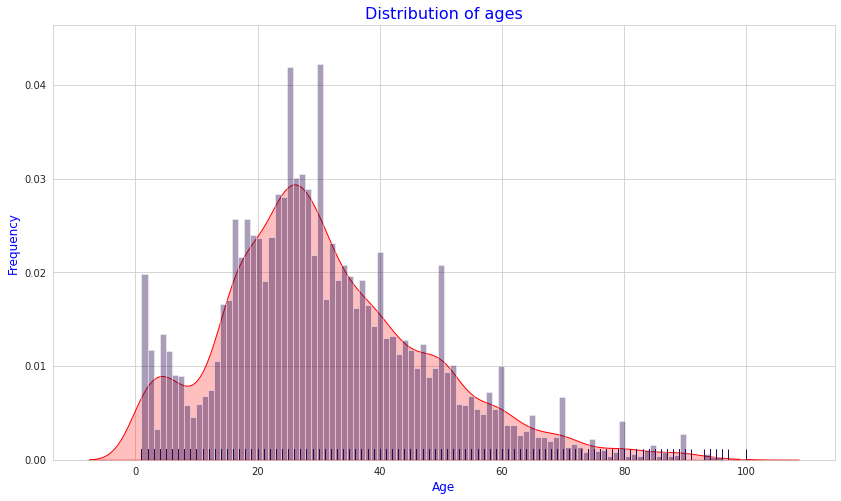

In [5]:
plt.figure(figsize=(14, 8))
sns.set_style('whitegrid')
sns.set_palette('inferno')
sns.distplot(labels['real_age'], rug=True, kde_kws={'shade':True, 'color':'r'}, bins=100)
plt.xlabel('Age', fontsize=12, color='b')
plt.ylabel('Frequency', fontsize=12, color='b')
plt.title('Distribution of ages', fontsize=16, color='b')
plt.show()

Most buyers are between 20 and 40 years old. At the same time, the data includes buyers of all ages, both under 10 and over 90.

Before training the model, let's display several photos with the age of the customers.

In [6]:
features, target = next(train_gen_flow)

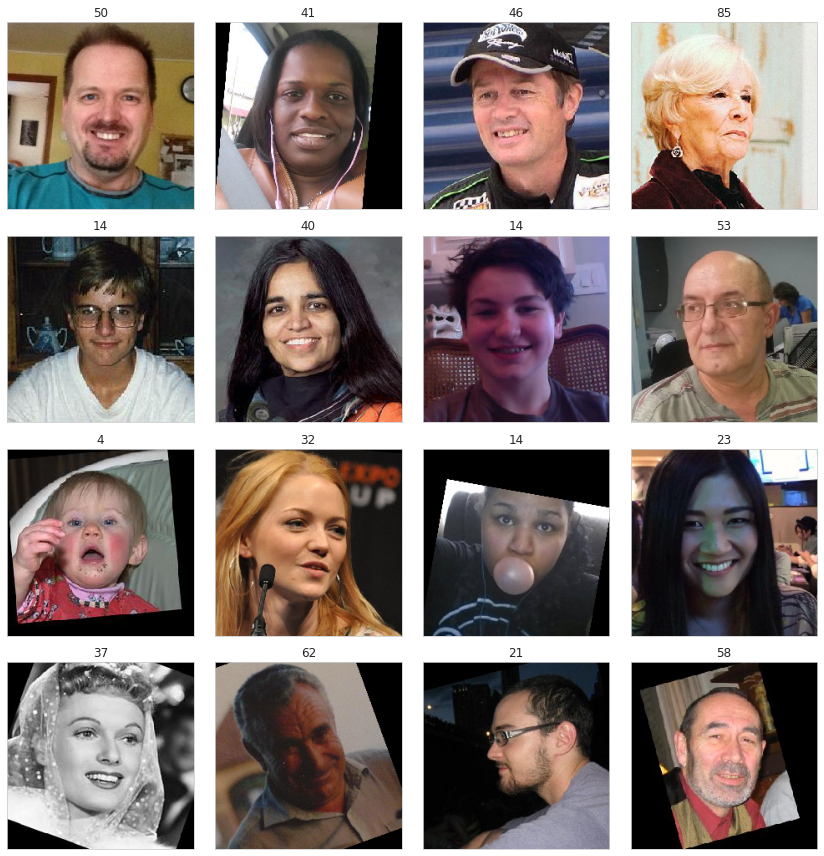

In [7]:
fig = plt.figure(figsize=(12,12))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Thus, we can see that our dataset contains a variety of portraits of customers of all ages. Some of the photographs are rotated, some are taken from the side, and there are also black and white photographs and photographs with varying brightness and clarity.

## Model Training

Now let's run a model based on the ResNet50 architecture using the Adam algorithm to optimize the learning rate of gradient descent.

```python

import pandas as pd

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                        horizontal_flip=True,
                                        rescale=1./255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels, 
                                                       directory=path + 'final_files/', 
                                                       x_col='file_name', 
                                                       y_col='real_age', 
                                                       target_size=(224, 224), 
                                                       batch_size=16, 
                                                       class_mode='raw',
                                                       subset='training', 
                                                       seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                      rescale=1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=labels, 
                                                     directory=path + 'final_files/', 
                                                     x_col='file_name', 
                                                     y_col='real_age', 
                                                     target_size=(224, 224), 
                                                     batch_size=16, 
                                                     class_mode='raw', 
                                                     subset='validation', 
                                                     seed=12345)
 
    return test_gen_flow
 
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model
```

```

Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

Train for 356 steps, validate for 119 steps

Epoch 1/20

2022-10-14 15:14:23.635390: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2022-10-14 15:14:23.926225: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

356/356 - 48s - loss: 217.3906 - mae: 10.5748 - val_loss: 475.3349 - val_mae: 16.5035

Epoch 2/20

356/356 - 39s - loss: 86.5213 - mae: 7.1071 - val_loss: 154.0334 - val_mae: 9.4647

Epoch 3/20

356/356 - 38s - loss: 58.1267 - mae: 5.8353 - val_loss: 83.0129 - val_mae: 6.9368

Epoch 4/20

356/356 - 38s - loss: 42.4940 - mae: 4.9725 - val_loss: 108.7451 - val_mae: 7.7472

Epoch 5/20

356/356 - 39s - loss: 32.8146 - mae: 4.3549 - val_loss: 69.8854 - val_mae: 6.1234

Epoch 6/20

356/356 - 39s - loss: 22.8092 - mae: 3.6727 - val_loss: 76.9867 - val_mae: 6.5090

Epoch 7/20

356/356 - 38s - loss: 19.3674 - mae: 3.3740 - val_loss: 69.9384 - val_mae: 6.2206

Epoch 8/20

356/356 - 38s - loss: 17.8467 - mae: 3.2142 - val_loss: 69.5787 - val_mae: 6.2129

Epoch 9/20

356/356 - 39s - loss: 16.3120 - mae: 3.0860 - val_loss: 66.6078 - val_mae: 6.1177

Epoch 10/20

356/356 - 38s - loss: 15.2968 - mae: 2.9512 - val_loss: 65.4643 - val_mae: 6.0717

Epoch 11/20

356/356 - 39s - loss: 13.2659 - mae: 2.7694 - val_loss: 63.6398 - val_mae: 5.9337

Epoch 12/20

356/356 - 38s - loss: 12.5737 - mae: 2.6999 - val_loss: 66.3250 - val_mae: 6.1946

Epoch 13/20

356/356 - 39s - loss: 11.6649 - mae: 2.6051 - val_loss: 71.4411 - val_mae: 6.2555

Epoch 14/20

356/356 - 39s - loss: 11.7297 - mae: 2.6121 - val_loss: 68.0171 - val_mae: 6.1991

Epoch 15/20

356/356 - 39s - loss: 10.9230 - mae: 2.5203 - val_loss: 63.2637 - val_mae: 5.7668

Epoch 16/20

356/356 - 38s - loss: 10.1997 - mae: 2.4366 - val_loss: 68.8021 - val_mae: 6.4516

Epoch 17/20

356/356 - 39s - loss: 9.8114 - mae: 2.3823 - val_loss: 62.2044 - val_mae: 5.8284

Epoch 18/20

356/356 - 39s - loss: 10.3688 - mae: 2.4452 - val_loss: 63.2759 - val_mae: 5.8219

Epoch 19/20

356/356 - 38s - loss: 9.4548 - mae: 2.3391 - val_loss: 62.2628 - val_mae: 5.9162

Epoch 20/20

356/356 - 38s - loss: 8.4395 - mae: 2.2148 - val_loss: 61.8180 - val_mae: 5.8078


```

## Conclusion

According to the results of the model, we got the value of the MAE - 5.81 on the test data. Thus, our model has overcome the threshold of MAE = 8 and can be used by the client to accurately determine the age of customers on a photo.